# Goal

In this competition, you are challenged to develop a model capable of predicting the closing price movements for hundreds of Nasdaq listed stocks using data from the order book and the closing auction of the stock. Information from the auction can be used to adjust prices, assess supply and demand dynamics, and identify trading opportunity.

Stock exchanges are fast-paced, high-stakes environments where every second counts. The intensity escalates as the trading day approaches its end, peaking in the critical final ten minutes. These moments, often characterised by heightened volatility and rapid price fluctuations, play a pivotal role in shaping the global economic narrative for the day.

Each trading day on the Nasdaq Stock Exchange concludes with the Nasdaq Closing Cross auction. This process establishes the official closing prices for securities listed on the exchange. These closing prices serve as key indicators for investors, analysts and other market participants in evaluating the performance of individual securities and the market as a whole.

Within this complex financial landscape operates Optiver, a leading global electronic market maker. Fueled by technological innovation, Optiver trades a vast array of financial instruments, such as derivatives, cash equities, ETFs, bonds, and foreign currencies, offering competitive, two-sided prices for thousands of these instruments on major exchanges worldwide.

In the last ten minutes of the Nasdaq exchange trading session, market makers like Optiver merge traditional order book data with auction book data. This ability to consolidate information from both sources is critical for providing the best prices to all market participants.

In this competition, you are challenged to develop a model capable of predicting the closing price movements for hundreds of Nasdaq listed stocks using data from the order book and the closing auction of the stock. Information from the auction can be used to adjust prices, assess supply and demand dynamics, and identify trading opportunities.

Your model can contribute to the consolidation of signals from the auction and order book, leading to improved market efficiency and accessibility, particularly during the intense final ten minutes of trading. You'll also get firsthand experience in handling real-world data science problems, similar to those faced by traders, quantitative researchers and engineers at Optiver.


# Description of the Files
- [train/test].csv - the auction data
- sample_submission - a valid sample submission
- revealed_targets - when the first time_id for each date (i.e. when seconds_in_bucket equals zero) the API will serve a dataframe providing the true target values for the entire previous date. All other rows contain null values for the columns of interest.
- public_timeseries_testing_util.py - an optional file intended to make it easier to run custom offline API tests. See the script's docstring for details. You will need to edit this file before using it.
- example_test_files/ - data intended to illustrate how the API functions. Includes the same files and columns delivered by the API. The first three date ids are repeats of the last three date ids in the train set, to enable an illustration of how the API functions.
- optiver2023/ - files that enable the API. Expect the API to deliver all rows in under five minutes and to reserve less than 0.5 GB of memory. The first three date ids delivered by the API are repeats of the last three date ids in the train set, to better illustrate how the API functions. You must make predictions for those dates in order to advance the API but those predictions are not scored.

# Target Metric
$$\text{MAE} = \dfrac{1}{n} \sum^n_{i=1} |y_i - x_i|,$$
where:
- $n$ is the total number of data points.
- $y_i$ is the predicted value for data point $i$.
- $x_i$ is the observed value for data point $i$.


# Imports

In [147]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython import display
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')


from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
# from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, ElasticNet
from  sklearn.linear_model import LinearRegression
from IPython.display import display

from sklearn.model_selection import TimeSeriesSplit
from catboost import Pool
from sklearn.metrics import mean_absolute_error


# Data Preprocessing and EDA

In [148]:
# read and print train dataframe
df = pd.read_csv('Optiver Trading Close/train.csv')
df = df.set_index('row_id')
test = pd.read_csv('Optiver Trading Close/example_test_files/test.csv')
test = test.set_index('row_id')
test_target = pd.read_csv('Optiver Trading Close/example_test_files/revealed_targets.csv')
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')
df.sample(5)

Number of rows: 5237980
Number of columns: 16


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
row_id,,,,,,,,,,,,,,,,
457_200_141,141,457,200,31423070.51,-1,0.997072,48396823.19,NaN,NaN,0.996926,20437.50,0.997145,39112.36,0.997001,4.420280,25155
137_240_149,149,137,240,1441533.87,1,0.999021,9486021.71,NaN,NaN,0.998610,58383.00,0.999021,26477.84,0.998892,3.520250,7559
377_170_9,9,377,170,260680.78,-1,1.001497,6752029.33,NaN,NaN,1.001497,18496.00,1.001714,9250.00,1.001641,3.459454,20752
213_180_28,28,213,180,0.00,0,1.000511,16657663.71,NaN,NaN,1.000511,160.48,1.000698,32262.51,1.000512,-3.020167,11733
450_310_85,85,450,310,0.00,0,1.001932,2850269.68,1.001932,1.001932,1.000640,650.68,1.002547,46123.34,1.000666,-2.580285,24781


Columns:
- stock_id - A unique identifier for the stock. Not all stock IDs exist in every time bucket.
- date_id - A unique identifier for the date. Date IDs are sequential & consistent across all stocks.
- imbalance_size - The amount unmatched at the current reference price (in USD).
- imbalance_buy_sell_flag - An indicator reflecting the direction of auction imbalance.
- - buy-side imbalance = 1
- - sell-side imbalance = -1
- - no imbalance = 0
- reference_price - The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.
- matched_size - The amount that can be matched at the current reference price (in USD).
- far_price - The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.
- near_price - The crossing price that will maximize the number of shares matched based auction and continuous market orders.
- [bid/ask]_price - Price of the most competitive buy/sell level in the non-auction book.
- [bid/ask]_size - The dollar notional amount on the most competitive buy/sell level in the non-auction book.
- wap - The weighted average price in the non-auction book.
$$\text{WAP} = \dfrac{BidPrice \cdot AskSize + AskPrice \cdot BidPrice}{BidSize + AskSize}$$
- seconds_in_bucket - The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.
- target - The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index. Only provided for the train set.
- - The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.
- - The unit of the target is basis points, which is a common unit of measurement in financial markets. A 1 basis point price move is equivalent to a 0.01% price move.
- - Where $t$ is the time at the current observation, we can define the target:

$$\text{Target} = \left( \dfrac{StockWAP_{t+60}}{StockWAP_t} - \dfrac{IndexWAP_{t+60}}{IndexWAP_t} \right) \cdot 10000$$

In [6]:
# get info about columns (analog of .describe() but with additional info)
def get_columns_info(df: pd.DataFrame) -> pd.DataFrame:
    info_df = pd.DataFrame({
        'Num Unique': df.nunique(),
        'Contain Null': df.isna().any(),
        'Num Null': df.isna().sum(),
        '% Null': round((df.isna().sum() / len(df)) * 100, 2),
        'dtype': df.dtypes
    })

    numeric_cols = df.select_dtypes(include=[np.number]).columns

    info_df['Mean'] = df[numeric_cols].mean()
    info_df['Mean'] = df[numeric_cols].std()
    info_df['Min'] = df[numeric_cols].min()
    info_df['1Q'] = df[numeric_cols].quantile(.25)
    info_df['Median'] = df[numeric_cols].median()
    info_df['3Q'] = df[numeric_cols].quantile(.75)
    info_df['Max'] = df[numeric_cols].max()

    non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
    for col in ['Min', '1Q', 'Median', '3Q', 'Max']:
        info_df.loc[non_numeric_cols, col] = '-'

    return info_df

get_columns_info(df)

,Num Unique,Contain Null,Num Null,% Null,dtype,Mean,Min,1Q,Median,3Q,Max
stock_id,200,False,0,0.00,int64,5.787176e+01,0.0,49.0,99.0,149.0,199.0
date_id,481,False,0,0.00,int64,1.385319e+02,0.0,122.0,242.0,361.0,480.0
seconds_in_bucket,55,False,0,0.00,int64,1.587451e+02,0.0,130.0,270.0,410.0,540.0
imbalance_size,2971863,True,220,0.00,float64,2.051591e+07,0.0,84534.15,1113604.44,4190951.0025,2982027811.68
imbalance_buy_sell_flag,3,False,0,0.00,int64,8.853374e-01,-1.0,-1.0,0.0,1.0,1.0
reference_price,28741,True,220,0.00,float64,2.532497e-03,0.935285,0.998763,0.999967,1.001174,1.077488
matched_size,2948862,True,220,0.00,float64,1.398413e+08,4316.61,5279575.165,12882638.56,32700130.58,7713682054.05
far_price,95739,True,2894342,55.26,float64,7.214705e-01,0.000077,0.996332,0.999883,1.003318,437.9531
near_price,84625,True,2857180,54.55,float64,1.216920e-02,0.786988,0.9971,0.999889,1.00259,1.309732
bid_price,28313,True,220,0.00,float64,2.499345e-03,0.934915,0.998529,0.999728,1.000905,1.077488


Here are some conclusion we can draw from this table:
- we have info about 200 stocks for 481 days. The time window for each day is 10 minutes and we have the info about price changes inside this window.
- for columns related to prices (`reference_price`, `far_price`, `near_price`, `bid_price`, `ask_price`) scaling is already applied, so we do not have to deal with the problem of difference in price values
- columns, related to size, should be scaled, because the difference between quartiles is high
- the structure of the dataset sets some restrictions on preprocessing because of the nature of the data, so we should be careful with it

In [9]:
COLOR = 'cornflowerblue'

numerical_cols = ['imbalance_size', 'reference_price', 'matched_size', 
                  'far_price', 'near_price', 'bid_price', 'ask_price', 
                  'bid_size', 'ask_size', 'wap', 'seconds_in_bucket', 'target']

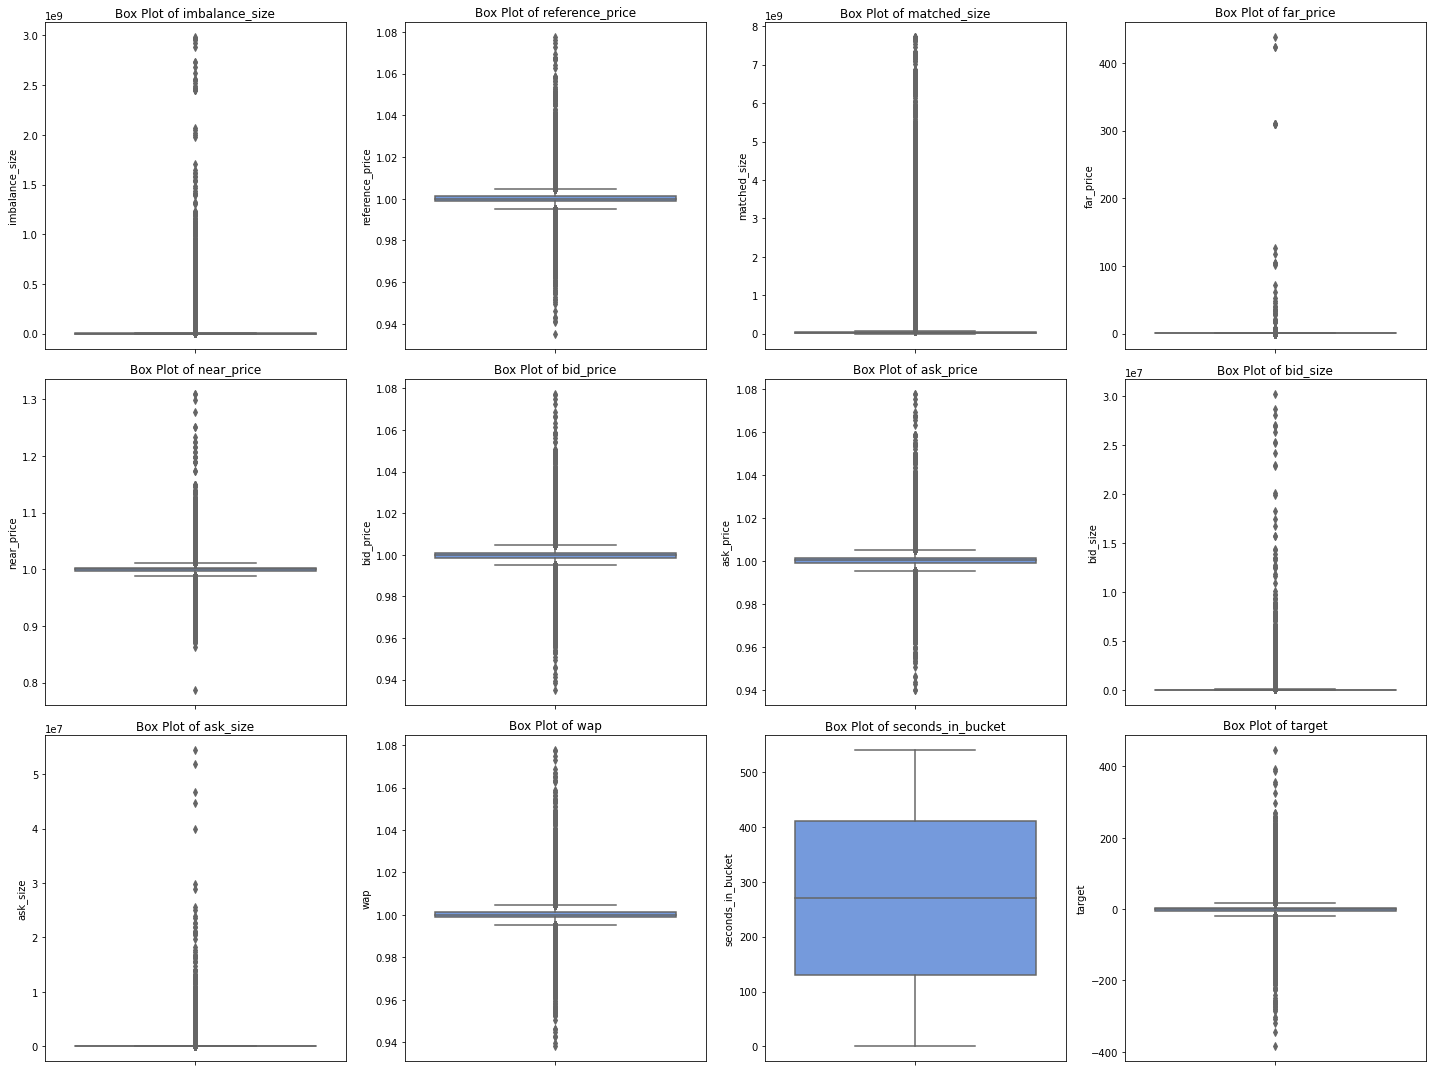

In [10]:
# Box Plots
n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, var in enumerate(numerical_cols):
    sns.boxplot(data=df, y=var, color=COLOR, ax=axes[i])
    axes[i].set_title(f'Box Plot of {var}')
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

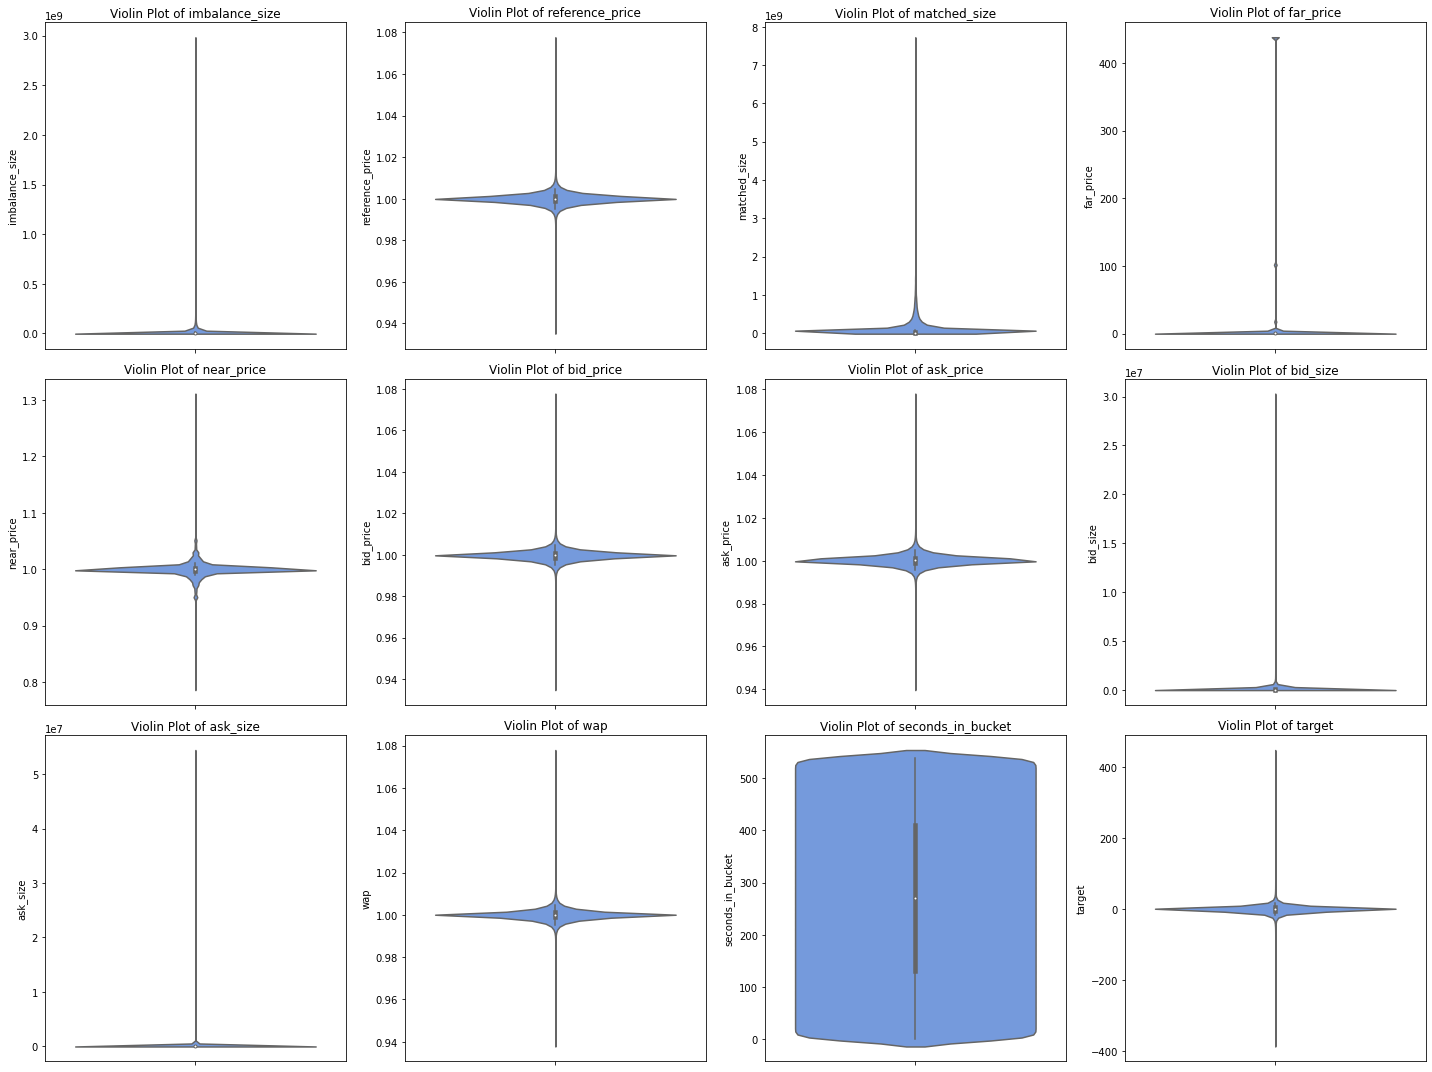

In [11]:
# Violin Plots
n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, var in enumerate(numerical_cols):
    sns.violinplot(data=df, y=var, color=COLOR, ax=axes[i])
    axes[i].set_title(f'Violin Plot of {var}')
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

All columns, except for `seconds_in_bucket` have bad box and violin distribution plots.
That is a clear sign that we should consider cleaning our data. Lets apply some techniques to get rid of outliers and see the new distributions. But first display the distributions we have now

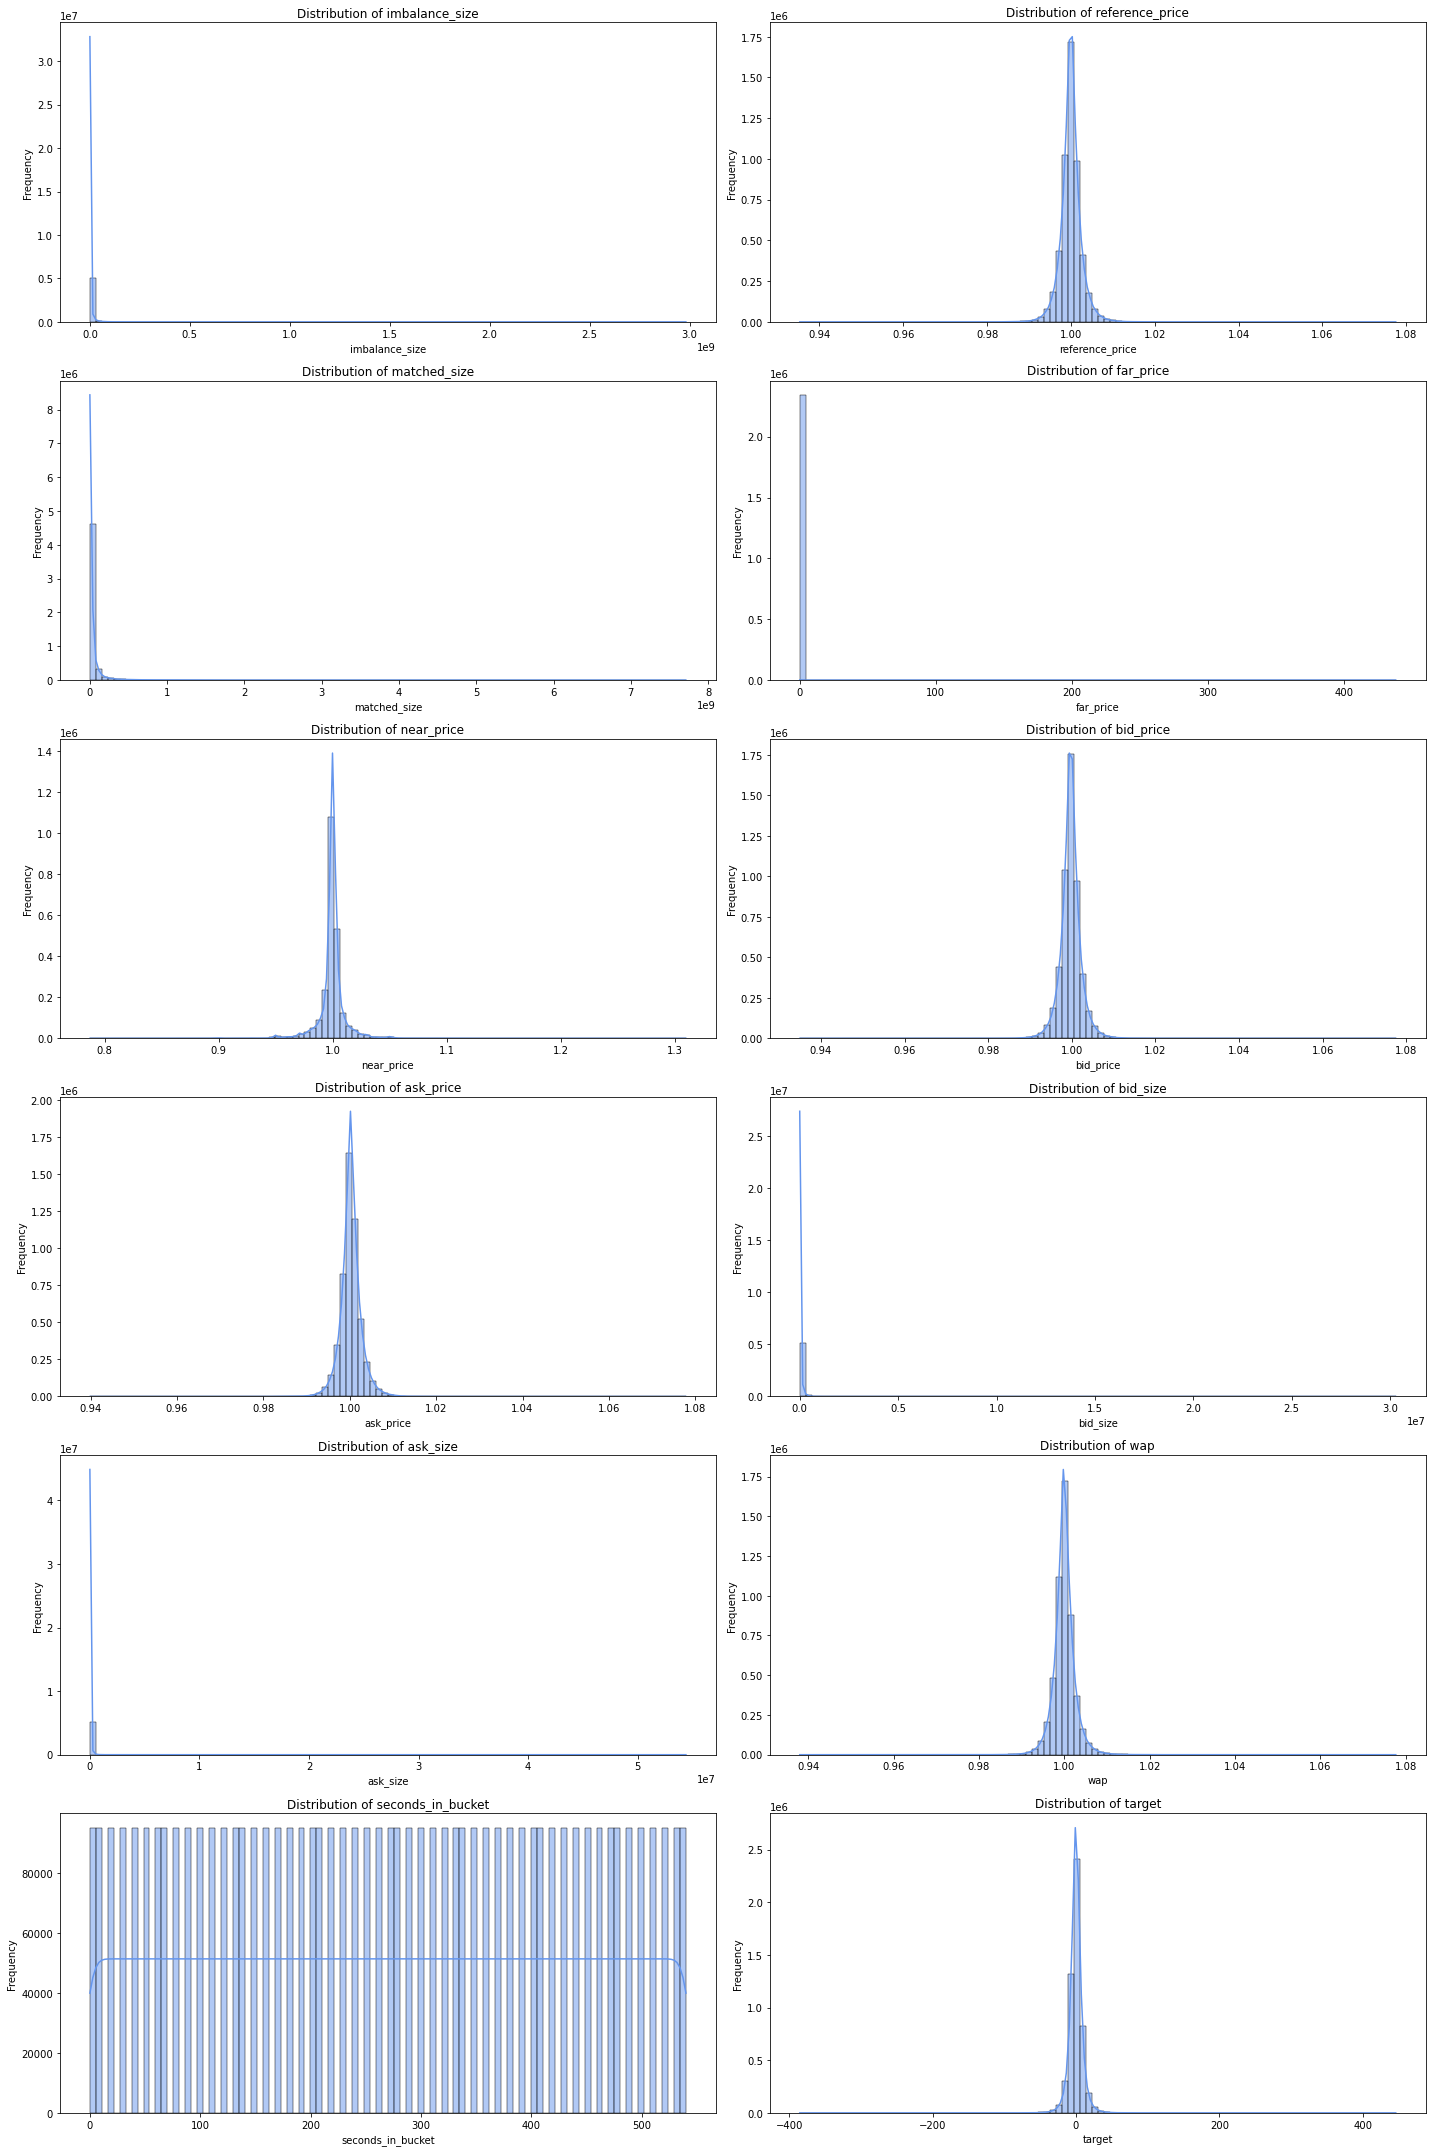

In [12]:
n_cols = 2
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, var in enumerate(numerical_cols):
    sns.histplot(df.sort_values(by=var, ascending=True)[var], bins=100, kde=True, color=COLOR, ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [10]:
# drop outliers using 3IQR method and plot new graphs
def three_iqr(df, columns, threshold):
    print('Method: 3IQR')
    outlier_counts = {}
    outlier_mask = pd.Series(data=False, index=df.index)
    initial_len = len(df)
    
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        column_outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
        outlier_mask = outlier_mask | column_outliers
        outlier_counts[column] = column_outliers.sum()
        print(f'Number of outliers in {column}: {outlier_counts[column]} ({round(outlier_counts[column] / initial_len, 2)}%)')
    
    new_df = df[~outlier_mask]
    print(f'Total number of outliers is {initial_len - len(new_df)}')
    print(f'Share of outliers is {1 - (len(new_df) / initial_len):.2f}')
        
    return new_df

In [11]:
new_df = three_iqr(df, numerical_cols, 1.5).reset_index(drop=True)

Method: 3IQR
Number of outliers in imbalance_size: 619374 (0.12%)
Number of outliers in reference_price: 320803 (0.06%)
Number of outliers in matched_size: 637237 (0.12%)
Number of outliers in far_price: 501784 (0.1%)
Number of outliers in near_price: 379172 (0.07%)
Number of outliers in bid_price: 324025 (0.06%)
Number of outliers in ask_price: 321691 (0.06%)
Number of outliers in bid_size: 509948 (0.1%)
Number of outliers in ask_size: 505021 (0.1%)
Number of outliers in wap: 325523 (0.06%)
Number of outliers in seconds_in_bucket: 0 (0.0%)
Number of outliers in target: 292263 (0.06%)
Total number of outliers is 2290075
Share of outliers is 0.44


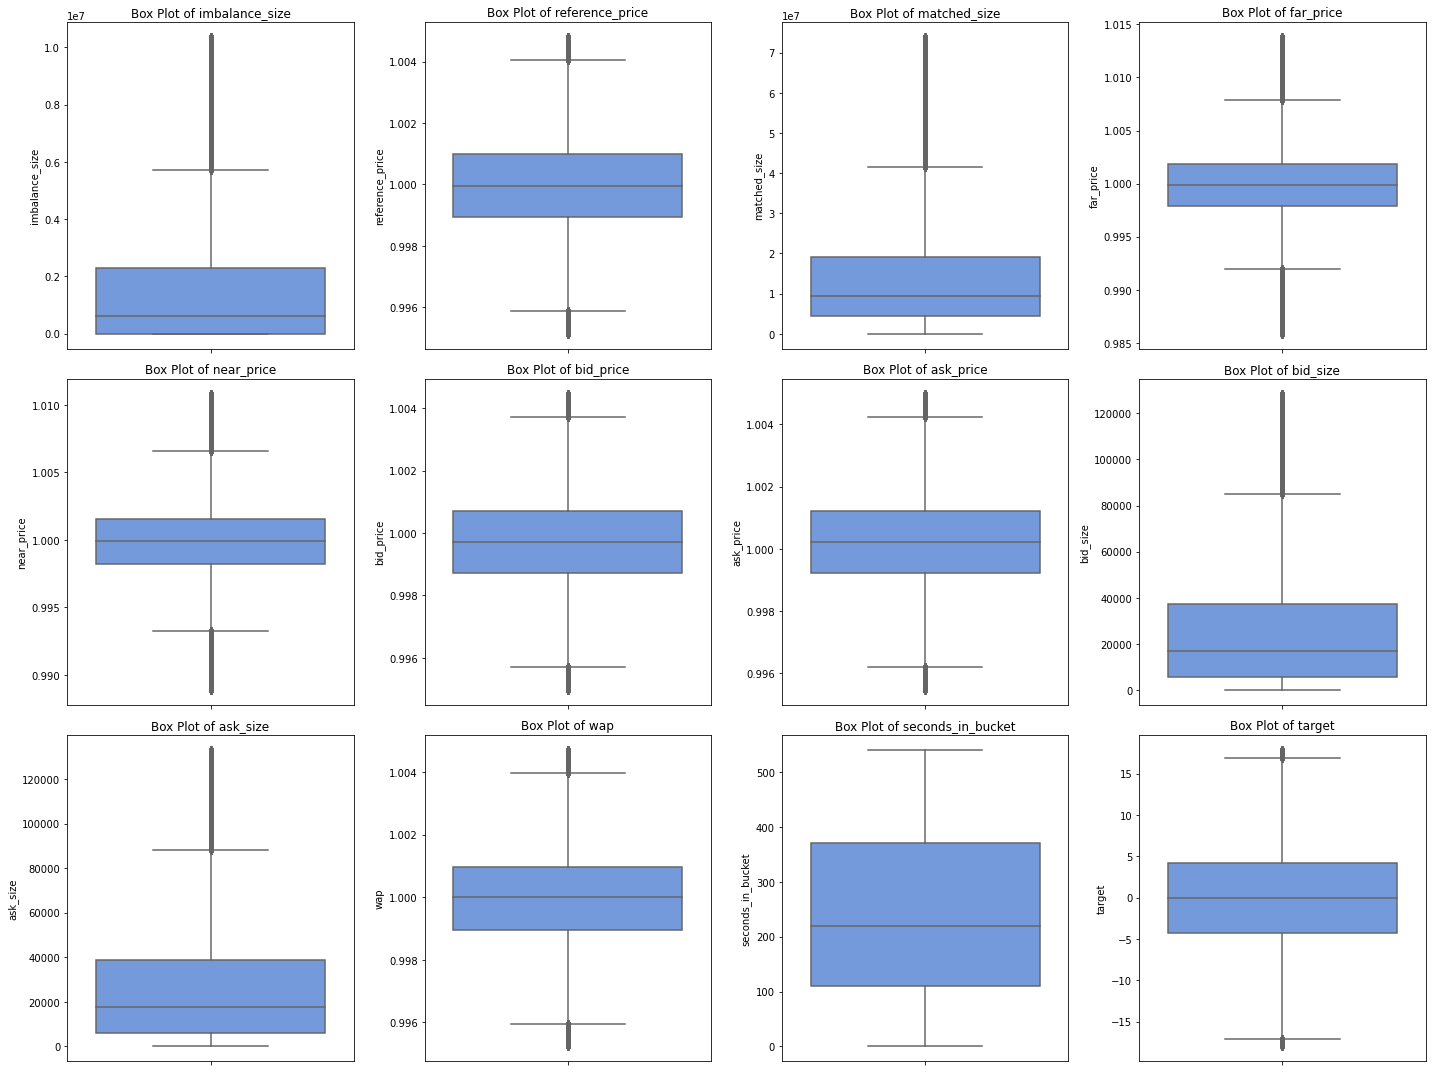

In [17]:
# Box Plots
n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, var in enumerate(numerical_cols):
    sns.boxplot(data=new_df, y=var, color=COLOR, ax=axes[i])
    axes[i].set_title(f'Box Plot of {var}')
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

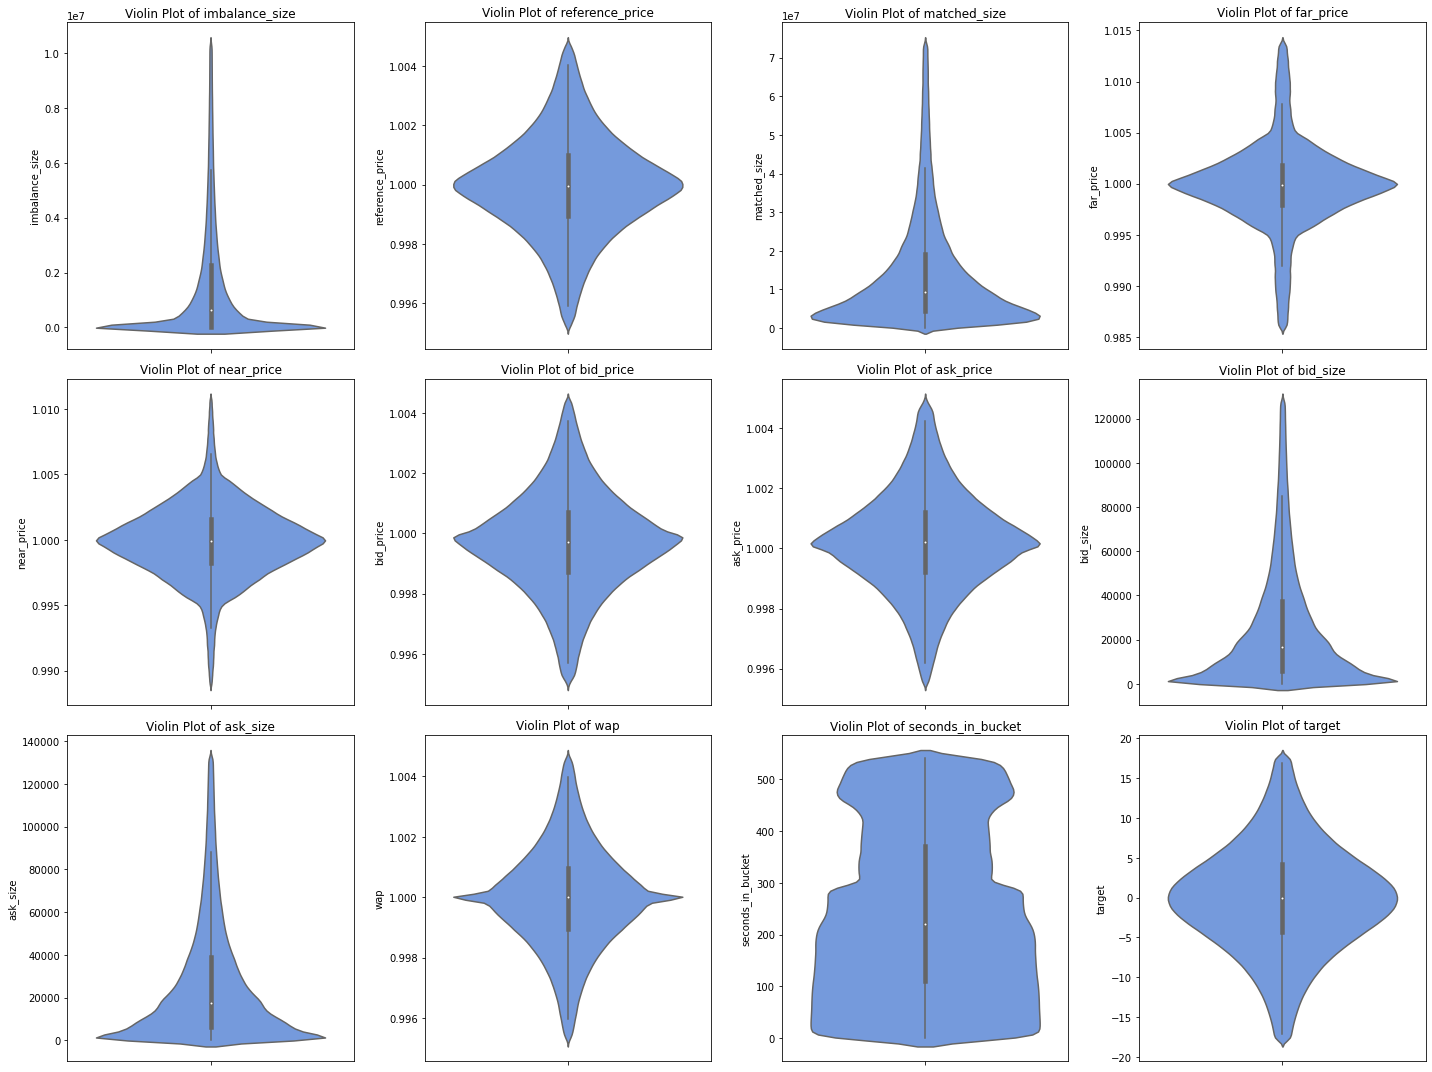

In [18]:
# Violin Plots
n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, var in enumerate(numerical_cols):
    sns.violinplot(data=new_df, y=var, color=COLOR, ax=axes[i])
    axes[i].set_title(f'Violin Plot of {var}')
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

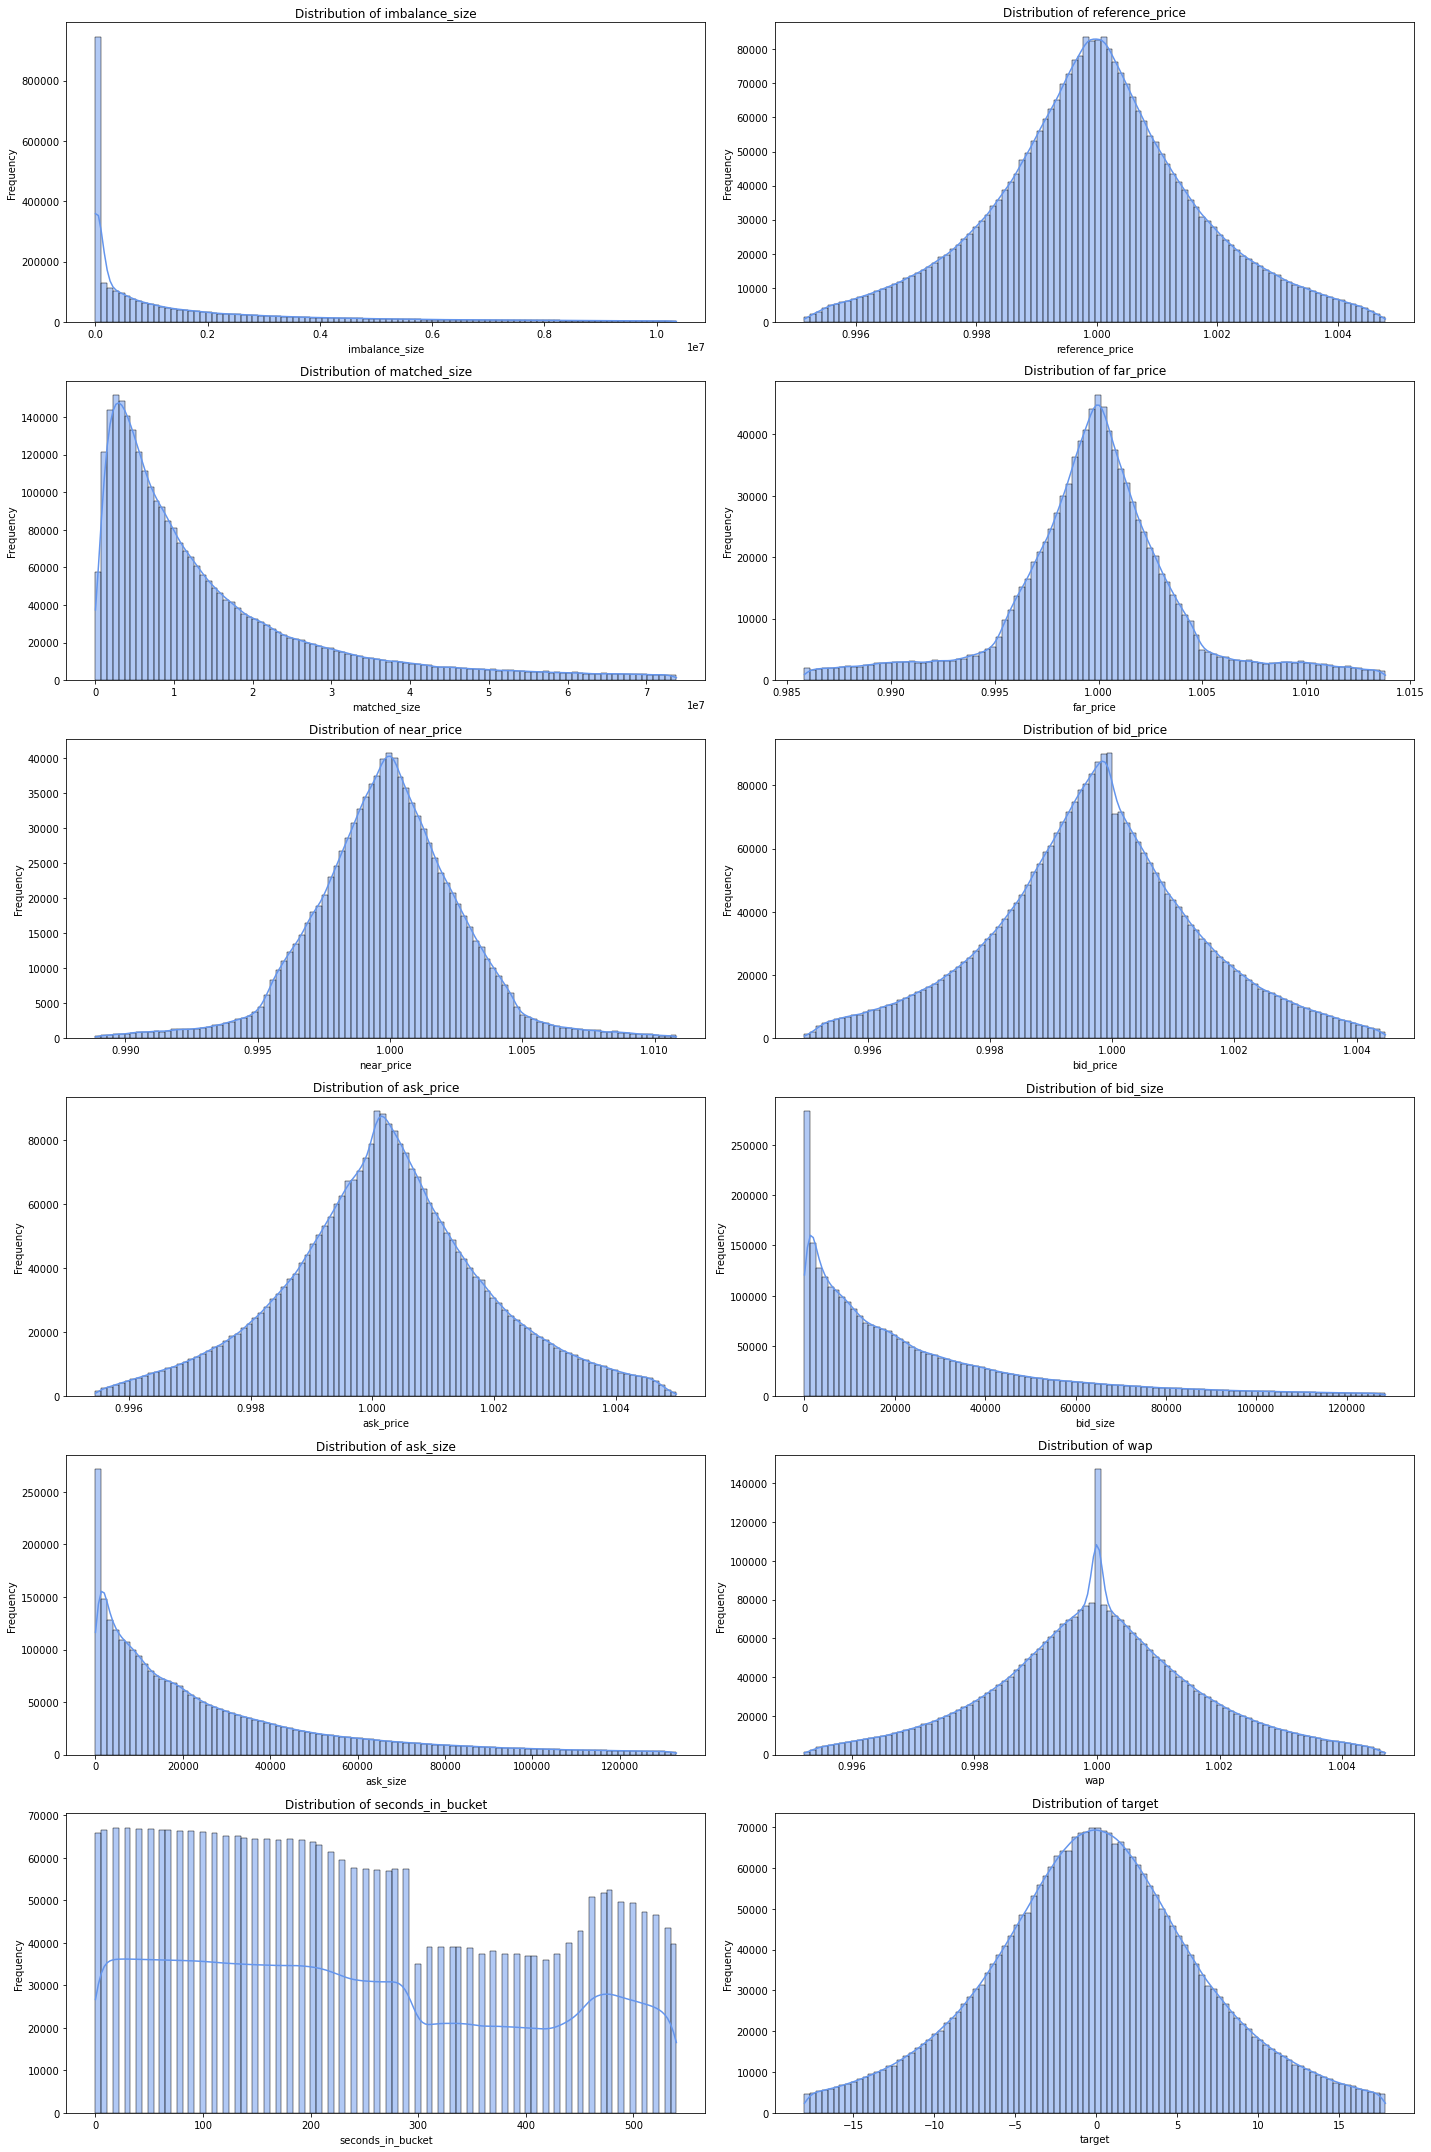

In [19]:
n_cols = 2
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, var in enumerate(numerical_cols):
    sns.histplot(new_df.sort_values(by=var, ascending=True)[var], bins=100, kde=True, color=COLOR, ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Baseline model creation

Let's create a baseline model for our data. We will use basic data handling techniques to understand, how our model perform on base data, without any 'hard' preprocessing made. This will help to understand, how efficient our future improvements are in terms of score

In [97]:
# Function to fill missing values 
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    # fill nans with mean values 
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

    stock_list = df['stock_id'].unique()
    for stock in stock_list:
        stock_df_indices = df['stock_id'] == stock

        for column in ['imbalance_size', 'reference_price', 'matched_size', 
                       'ask_price', 'wap', 'target', 'bid_price']:
            df.loc[stock_df_indices, column] = imp_mean.fit_transform(df.loc[stock_df_indices, [column]])
            
    return df

df_base = df.drop(['far_price', 'near_price'], axis=1)
df_base = preprocess_data(df_base)

In [98]:
# Split data to X,y, train, test
y = df_base['target']
X = df_base.drop(['target'], axis = 1)
X = X.drop(['time_id'], axis = 1)
test = test.drop(['time_id'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 23)

In [43]:
# Check performances of different models on cross validation. Some models might be commented because they gave a worse score, so we do not need to run them, 
# but kept in order to show that they were used before

models = {
    "XGBRegressor": XGBRegressor(n_estimators=50),
    "CatBoostRegressor": CatBoostRegressor(n_estimators=50, verbose=False, random_seed=42),
    # "LGBMRegressor": LGBMRegressor(n_estimators=100, verbose=0, force_col_wise=True, device="gpu"),
    # "RandomForestRegressor": RandomForestRegressor(n_estimators=100),
    "GradientBoostingRegressor": GradientBoostingRegressor(n_estimators=100),
    # "SVR": SVR(),
    "Ridge": Ridge(),
    # "ElasticNet": ElasticNet(),
    # "DecisionTreeRegressor": DecisionTreeRegressor(),
    "LinearRegression": LinearRegression()
    # "KNeighborsRegressor": KNeighborsRegressor(),
    # "AdaBoostRegressor": AdaBoostRegressor(n_estimators=100),
    # "ExtraTreesRegressor": ExtraTreesRegressor(n_estimators=100)
}

baseline_scores = pd.DataFrame({'Model':[],
                                'Score':[]})

for model_name, model in models.items():
    print(f'fitting {model_name}')
    pipeline = make_pipeline(model)
    cv_score = -1 * np.mean(cross_val_score(pipeline, X, y, cv=3, scoring='neg_mean_absolute_error'))
    baseline_scores = pd.concat([baseline_scores, pd.DataFrame(data={'Model': [model_name], 'Score': [cv_score]})])

fitting CatBoostRegressor
fitting GradientBoostingRegressor


KeyboardInterrupt: 

In [ ]:
baseline_scores.sort_values(by='Score')

In [94]:
test = test.drop(['far_price', 'near_price'], axis=1)


Our baseline score is **6.36**, the best model is `CatBoostRegressor`. So, that is the score we will compare our future models with.

## Function to predict in test

In [120]:
def fit_eval(model, train_data, target, params, preprocessing_func=(lambda x: x)):
    #params - hyperparameters

    X_train, y_train = train_data.drop(['time_id'] + [target], axis=1), train_data.target
    X_test, y_test = test, test_target
    y_test = y_test['revealed_target']
    y_test = y_test.dropna()

    X_train = preprocessing_func(X_train)
    X_test = preprocessing_func(X_test)

    m = model(**params)
    m.fit(X_train, y_train)
    train_pred = m.predict(X_train)
    pred = m.predict(X_test)
    # print(y_train.shape)
    print(f'Train MAE: {mean_absolute_error(y_train, train_pred)}, Test MAE: {mean_absolute_error(y_test, pred)}')

In [121]:
fit_eval(CatBoostRegressor, df_base, 'target', {'n_estimators':50, 'verbose':False, 'random_seed':42})

Train MAE: 6.300518957847724, Test MAE: 5.4952670849859695


# Increasing model score
Now let's think about some ways we can possibly increase out model's performance. The one thing which comes to mind first is to test it without outliers. The fact that our target metric is MAE, not MSE, really gives us a way to do it, because we can possibly end in the state, where more accurate predictions on 'normal' data will overweight worse predictions on outliers. From the business POV that might be bad, but considering the fact we are solving kaggle competition, we should do everything possible to get better score.

## Getting rid of ourliers in train data

In [24]:
# preprocess dataframe to fill values and drop nans
df_new = preprocess_data(df)

# split into train and test and drop outliers in train data while keep them in test
train, test = train_test_split(df_new, test_size=0.3, random_state=23)
train = three_iqr(train, numerical_cols, 1.5)

X_train = train.drop(['target', 'time_id', 'far_price', 'near_price'], axis=1)
y_train = train['target']

X_test = test.drop(['target', 'time_id', 'far_price', 'near_price'], axis=1)
y_test = test['target']

Method: 3IQR
Number of outliers in imbalance_size: 433954 (0.12%)
Number of outliers in reference_price: 224909 (0.06%)
Number of outliers in matched_size: 446358 (0.12%)
Number of outliers in far_price: 350764 (0.1%)
Number of outliers in near_price: 265207 (0.07%)
Number of outliers in bid_price: 227081 (0.06%)
Number of outliers in ask_price: 225427 (0.06%)
Number of outliers in bid_size: 357375 (0.1%)
Number of outliers in ask_size: 353006 (0.1%)
Number of outliers in wap: 227884 (0.06%)
Number of outliers in seconds_in_bucket: 0 (0.0%)
Number of outliers in target: 204562 (0.06%)
Total number of outliers is 1603351
Share of outliers is 0.44


In [25]:
# As we are going to try many differen approaches, we will define function to easily check for scores without repeating same parts many times
def get_scores(headline:str, models:dict, data:list) -> str:
    print(headline)
    X_train, y_train, X_test, y_test = data
    for model_name, model in models.items():
        cv_score = -1 * np.mean(cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_absolute_error'))
        print(f'{model_name} - CV MAE score: {cv_score:.3f}')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        test_mae = mean_absolute_error(y_test, y_pred)
        print(f'{model_name} - Test MAE score: {test_mae:.3f} \n')

In [26]:
models = {
    "CatBoostRegressor": CatBoostRegressor(n_estimators=50, verbose=False, random_seed=42),
    "LinearRegression": LinearRegression(fit_intercept=True)
}

data = [X_train, y_train, X_test, y_test]

get_scores(headline='Base model without outliers', models=models, data=data)

Base model without outliers
CatBoostRegressor - CV MAE score: 5.191
CatBoostRegressor - Test MAE score: 6.312 

LinearRegression - CV MAE score: 5.202
LinearRegression - Test MAE score: 6.334 



We can see, that it does not really increased score much: we only increased it by **.15**. Therefore, outliers does not really affect our results

## Upgrade preprocessing of data

There are some logical things we can make in order to improve initial data:
- *apply better scaling for features*: select features we need to scale and scale them with the respect to stock_id (IMO it is the best in terms of specifying the max params and making model simple. We cannot pay attention for both stock_id and time-relative features as we wont have them in test data)
- *check correlation plot and drop most correlated features*: they can affect weights of the final model so we wanna get rid of them
- *apply better na filling*: pay respect to many parameters

Also, there are a bunch of technical things to do:
- *apply tuning to models*: find best params to minimize our target error

We have already seen, that some columns have been initially prescaled, so we can use info table to find the exact list of columns we should scale. These columns are:
matched_size, bid_size, ask_size

### Scaling columns

In [39]:
def scale_data(df: pd.DataFrame, scaler_dict=None) -> (pd.DataFrame, dict):    
    # initialize dict to save scalers for future use on test dataset
    if scaler_dict is None:
        scaler_dict = {}

    stock_list = df['stock_id'].unique()
    
    for stock in stock_list:
        stock_indices = df[df['stock_id'] == stock].index
        
        if stock not in scaler_dict:
            scaler = StandardScaler()
            df.loc[stock_indices, ['matched_size', 'bid_size', 'ask_size']] = scaler.fit_transform(df.loc[stock_indices, ['matched_size', 'bid_size', 'ask_size']])
            scaler_dict[stock] = scaler
        else:
            scaler = scaler_dict[stock]
            df.loc[stock_indices, ['matched_size', 'bid_size', 'ask_size']] = scaler.transform(df.loc[stock_indices, ['matched_size', 'bid_size', 'ask_size']])

    return df, scaler_dict

df_scaled, scaler_dict = scale_data(df_base)

In [41]:
get_columns_info(df_scaled)

,Num Unique,Contain Null,Num Null,% Null,dtype,Mean,Min,1Q,Median,3Q,Max
stock_id,200,False,0,0.0,int64,5.787176e+01,0.0,49.0,99.0,149.0,199.0
date_id,481,False,0,0.0,int64,1.385319e+02,0.0,122.0,242.0,361.0,480.0
seconds_in_bucket,55,False,0,0.0,int64,1.587451e+02,0.0,130.0,270.0,410.0,540.0
imbalance_size,2971867,False,0,0.0,float64,2.051549e+07,0.0,84566.63,1113665.26,4190638.9775,2982027811.68
imbalance_buy_sell_flag,3,False,0,0.0,int64,8.853374e-01,-1.0,-1.0,0.0,1.0,1.0
reference_price,28745,False,0,0.0,float64,2.532444e-03,0.935285,0.998763,0.999967,1.001174,1.077488
matched_size,2949727,False,0,0.0,float64,1.000000e+00,-1.401311,-0.369334,-0.166405,0.058712,27.322603
bid_price,28317,False,0,0.0,float64,2.499294e-03,0.934915,0.998529,0.999728,1.000905,1.077488
bid_size,4879119,False,0,0.0,float64,1.000000e+00,-1.564295,-0.502473,-0.253116,0.155491,128.864492
ask_price,28270,False,0,0.0,float64,2.509991e-03,0.939827,0.999029,1.000207,1.001414,1.077836


In [42]:
# split into train and test and drop outliers in train data while keep them in test
train, test = train_test_split(df_scaled, test_size=0.3, random_state=23)

X_train = train.drop(['target', 'time_id'], axis=1)
y_train = train['target']

X_test = test.drop(['target', 'time_id'], axis=1)
y_test = test['target']

In [43]:
models = {
    "CatBoostRegressor": CatBoostRegressor(n_estimators=50, verbose=False, random_seed=42),
    "LinearRegression": LinearRegression(fit_intercept=True)
}

data = [X_train, y_train, X_test, y_test]

get_scores(headline='Scaled data', models=models, data=data)

Scaled data
CatBoostRegressor - CV MAE score: 6.320
CatBoostRegressor - Test MAE score: 6.316 

LinearRegression - CV MAE score: 6.323
LinearRegression - Test MAE score: 6.318 



### Correlation plot analysis

We will always use the most pure form of our dataset (i.t. original dataset with simple imputes for nans), so that we can compare results in some 'sterile' conditions

In [53]:
df_base = preprocess_data(df)

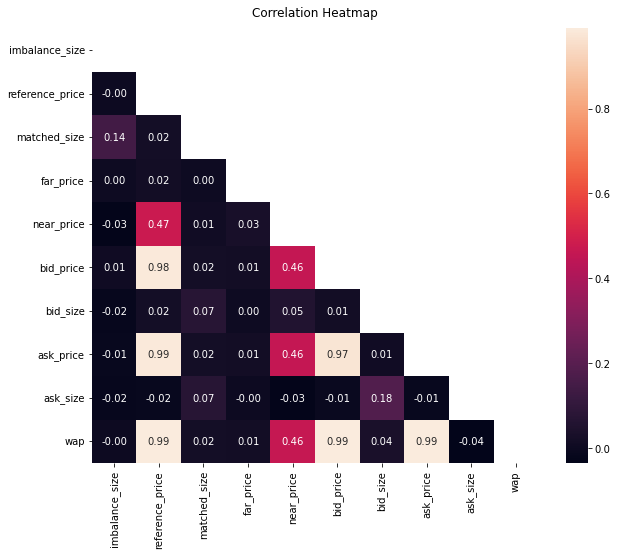

In [46]:
corr = df_base[['imbalance_size', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap']].corr()
matrix = np.triu(corr)
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", xticklabels=corr.columns, yticklabels=corr.columns, mask=matrix)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.show()

We can see, that there are high correlations between those pairs of features (we write all pairs only once for the first intake in columns):
- imbalance_size  <-> matched_price (1)
- reference_price <-> near_price, bid_price, ask_price, wap (4)
- matched_size    <-> imbalance_size (1)
- near_price      <-> reference_price, bid_price, ask_price, bid_price (4)
- bid_price       <-> referenc_price, wap, ask_price (3)
- ask_price       <-> reference_price, bid_price, wap (3)
- wap             <-> reference_price, bid_price, ask_price, near_price (4)

As the result, we have this number of presence for every feature:
- 4: reference_price, near_price, wap
- 3: bid_price, ask_price
- 1: imbalance_size, matched_size

Therefore, we might consider dropping near_price, ask_price (other columns rather have more general impact on the data or less correlated with other features)

In [54]:
df_base_corr = df_base.drop(['near_price', 'ask_price'], axis=1)

In [55]:
df_base_corr.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                   0
imbalance_buy_sell_flag          0
reference_price                  0
matched_size                     0
far_price                  2894342
bid_price                        0
bid_size                         0
ask_size                         0
wap                              0
target                           0
time_id                          0
dtype: int64

In [60]:
y = df_base_corr['target']
X = df_base_corr.drop(['target'], axis = 1)
X = X.drop(['time_id'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 23)

In [61]:
models = {
    "CatBoostRegressor": CatBoostRegressor(n_estimators=50, verbose=False, random_seed=42),
    "LinearRegression": LinearRegression(fit_intercept=True)
}

for model_name, model in models.items():
    pipeline = make_pipeline(model)
    cv_score = -1 * np.mean(cross_val_score(pipeline, X, y, cv=3, scoring='neg_mean_absolute_error'))
    print(f'{model_name} score = {cv_score:.3f}')
    
    pipeline.fit(X, y)

    if model_name == "CatBoostRegressor":
        feature_importance = model.get_feature_importance()
    elif model_name == "LinearRegression":
        feature_importance = np.abs(model.coef_)
    if feature_importance is not None:
        feature_names = X.columns

        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importance
        })

        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

        print(f'Feature Importances for {model_name}')
        display(feature_importance_df)

CatBoostRegressor score = 6.373
Feature Importances for CatBoostRegressor


,Feature,Importance
11,wap,17.767020
2,seconds_in_bucket,12.451558
5,reference_price,11.202330
9,bid_size,10.644191
8,bid_price,10.018032
10,ask_size,8.221727
7,far_price,8.169201
4,imbalance_buy_sell_flag,6.002251
1,date_id,5.615395
6,matched_size,3.798223


LinearRegression score = 6.353
Feature Importances for LinearRegression


,Feature,Importance
11,wap,3.928585e+03
5,reference_price,2.369059e+03
8,bid_price,1.444859e+03
10,ask_size,1.378298e-01
9,bid_size,1.135168e-01
4,imbalance_buy_sell_flag,1.080091e-01
7,far_price,1.772367e-02
6,matched_size,6.280897e-03
2,seconds_in_bucket,6.029407e-04
0,stock_id,2.467208e-04


### Apply better filling

In [66]:
def fill_nans_with_median(df: pd.DataFrame, columns_to_fill, median_dict=None) -> (pd.DataFrame, dict):
    if median_dict is None:
        median_dict = {stock: {} for stock in df['stock_id'].unique()}
    
    for stock in df['stock_id'].unique():
        stock_rows = df['stock_id'] == stock
        for column in columns_to_fill:
            if column not in median_dict[stock]:
                median_dict[stock][column] = df.loc[stock_rows, column].median()
    
    for stock, medians in median_dict.items():
        stock_rows = df['stock_id'] == stock
        for column in columns_to_fill:
            df.loc[stock_rows, column] = df.loc[stock_rows, column].fillna(medians[column])
    
    return df, median_dict

columns_to_fill = ['imbalance_size', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'wap']
df_filled, median_dict = fill_nans_with_median(df_base, columns_to_fill)

In [67]:
# split into train and test and drop outliers in train data while keep them in test
train, test = train_test_split(df_filled, test_size=0.3, random_state=23)

X_train = train.drop(['target', 'time_id'], axis=1)
y_train = train['target']

X_test = test.drop(['target', 'time_id'], axis=1)
y_test = test['target']

In [68]:
get_columns_info(df_filled)

,Num Unique,Contain Null,Num Null,% Null,dtype,Mean,Min,1Q,Median,3Q,Max
stock_id,200,False,0,0.0,int64,5.787176e+01,0.0,49.0,99.0,149.0,199.0
date_id,481,False,0,0.0,int64,1.385319e+02,0.0,122.0,242.0,361.0,480.0
seconds_in_bucket,55,False,0,0.0,int64,1.587451e+02,0.0,130.0,270.0,410.0,540.0
imbalance_size,2971867,False,0,0.0,float64,2.051549e+07,0.0,84566.63,1113665.26,4190638.9775,2982027811.68
imbalance_buy_sell_flag,3,False,0,0.0,int64,8.853374e-01,-1.0,-1.0,0.0,1.0,1.0
reference_price,28745,False,0,0.0,float64,2.532444e-03,0.935285,0.998763,0.999967,1.001174,1.077488
matched_size,2949727,False,0,0.0,float64,1.000000e+00,-1.401311,-0.369334,-0.166405,0.058712,27.322603
far_price,95762,False,0,0.0,float64,4.825949e-01,0.000077,0.999416,0.999864,1.000473,437.9531
near_price,84628,False,0,0.0,float64,8.209927e-03,0.786988,0.999496,0.999879,1.000409,1.309732
bid_price,28317,False,0,0.0,float64,2.499294e-03,0.934915,0.998529,0.999728,1.000905,1.077488


In [69]:
models = {
    "CatBoostRegressor": CatBoostRegressor(n_estimators=50, verbose=False, random_seed=42),
    "LinearRegression": LinearRegression(fit_intercept=True)
}

data = [X_train, y_train, X_test, y_test]

get_scores(headline='Applied better preprocessing', models=models, data=data)

Base model without outliers
CatBoostRegressor - CV MAE score: 6.320
CatBoostRegressor - Test MAE score: 6.312 

LinearRegression - CV MAE score: 6.322
LinearRegression - Test MAE score: 6.318 



### Upgrade preprocessing of data
Now, let's analyze the importance of `far_price` and `near_price`, which we dropped in our initial model. 

Nasdaq provides an indication of the fair price called the reference price. The reference price is calculated as follows:
- If the near price is between the best bid and ask, then the reference price is equal to the near price
- If the near price > best ask, then reference price = best ask
- If the near price < best bid, then reference price = best bid So the reference price is the near price bounded between the best bid and ask.

Filling this features might help us to get more valuable features for the model

In [118]:
def near_price_filler(data: pd.DataFrame) -> pd.DataFrame:
    data_for_fill = (data['seconds_in_bucket'] >= 300) & (data['near_price'].isna())

    mask_bid_eq_ref = (data['bid_price'] == data['reference_price']) & data_for_fill
    mask_for_equality = ((data['bid_price'] < data['reference_price']) \
                        & (data['reference_price'] < data['ask_price'])) & data_for_fill
    mask_ask_eq_ref = (data['ask_price'] == data['reference_price']) & data_for_fill

    print("Rows to fill for bid_eq_ref:", mask_bid_eq_ref.sum())
    print("Rows to fill for for_equality:", mask_for_equality.sum())
    print("Rows to fill for ask_eq_ref:", mask_ask_eq_ref.sum())

    data.loc[mask_bid_eq_ref, 'near_price'] = data.loc[mask_bid_eq_ref, 'reference_price'] - np.std(data['reference_price'])
    data.loc[mask_for_equality, 'near_price'] = data.loc[mask_for_equality, 'reference_price']
    data.loc[mask_ask_eq_ref, 'near_price'] = data.loc[mask_ask_eq_ref, 'reference_price'] + np.std(data['reference_price'])

    return data

def far_price_filler(data: pd.DataFrame) -> pd.DataFrame:
    data_for_fill = (data['seconds_in_bucket'] >= 300) & (data['far_price'].isna())

    data.loc[data_for_fill, 'far_price'] = data.loc[data_for_fill, 'near_price']

    return data

# Example usage
df_n = near_price_filler(df)
df_n = far_price_filler(df_n)

df_n.isna().sum()


Rows to fill for bid_eq_ref: 0
Rows to fill for for_equality: 0
Rows to fill for ask_eq_ref: 0


stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2857180
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

In [106]:
df.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

In [105]:
df[['stock_id']]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [107]:
# Function to fill missing near_price values
def near_price_filler(data: pd.DataFrame) -> pd.DataFrame:
    # data = dataframe.copy()
    data_for_fill = (data['seconds_in_bucket'] >= 300) & (data['near_price'].isna())
    
    
    # Replace missing 'near_price' values based on conditions
    mask_bid_eq_ref = (data['bid_price'] == data['reference_price']) & data_for_fill
    mask_for_equality = ((data['bid_price'] < data['reference_price']) \
                       & (data['reference_price'] < data['ask_price'])) & data_for_fill
    mask_ask_eq_ref = (data['ask_price'] == data['reference_price']) & data_for_fill
    
    data.loc[mask_bid_eq_ref, 'near_price'] = data.loc[mask_bid_eq_ref, 'reference_price']\
                                                    - np.std(df['reference_price'])
    data.loc[mask_for_equality, 'near_price'] = data.loc[mask_for_equality, 'reference_price']
    data.loc[mask_ask_eq_ref, 'near_price'] = data.loc[mask_ask_eq_ref, 'reference_price']\
                                                    + np.std(df['reference_price'])
    
    return data

# Function to fill missing far_price values
def far_price_filler(data: pd.DataFrame) -> pd.DataFrame:
    # data = dataframe.copy()
    data_for_fill = (data['seconds_in_bucket'] >= 300) & (data['far_price'].isna())
    
    # Replace missing 'near_price' values based on conditions
    data.loc[data_for_fill, 'far_price'] = data.loc[data_for_fill, 'near_price']
        
    return data

In [117]:
def near_price_filler(data: pd.DataFrame) -> pd.DataFrame:
    data_for_fill = (data['seconds_in_bucket'] >= 300) & (data['near_price'].isna())

    mask_bid_eq_ref = (data['bid_price'] == data['reference_price']) & data_for_fill
    mask_for_equality = ((data['bid_price'] < data['reference_price']) \
                        & (data['reference_price'] < data['ask_price'])) & data_for_fill
    mask_ask_eq_ref = (data['ask_price'] == data['reference_price']) & data_for_fill

    print("Rows to fill for bid_eq_ref:", mask_bid_eq_ref.sum())
    print("Rows to fill for for_equality:", mask_for_equality.sum())
    print("Rows to fill for ask_eq_ref:", mask_ask_eq_ref.sum())

    data.loc[mask_bid_eq_ref, 'near_price'] = data.loc[mask_bid_eq_ref, 'reference_price'] - np.std(data['reference_price'])
    data.loc[mask_for_equality, 'near_price'] = data.loc[mask_for_equality, 'reference_price']
    data.loc[mask_ask_eq_ref, 'near_price'] = data.loc[mask_ask_eq_ref, 'reference_price'] + np.std(data['reference_price'])

    return data

def far_price_filler(data: pd.DataFrame) -> pd.DataFrame:
    data_for_fill = (data['seconds_in_bucket'] >= 300) & (data['far_price'].isna())

    data.loc[data_for_fill, 'far_price'] = data.loc[data_for_fill, 'near_price']

    return data

# Example usage
df_n = near_price_filler(df)
df_n = far_price_filler(df_n)

df_n.isna().sum()


Rows to fill for bid_eq_ref: 0
Rows to fill for for_equality: 0
Rows to fill for ask_eq_ref: 0


stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2857180
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

In [77]:
# Modify our initial preprocessing function
def improved_preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    df.set_index("row_id", inplace=True)
    # df.drop(['far_price', 'near_price'], axis=1, inplace=True)

    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

    stock_list = df['stock_id'].unique()
    for stock in stock_list:
        stock_df_indices = df['stock_id'] == stock

        for column in ['imbalance_size', 'reference_price', 'matched_size', 
                       'ask_price', 'wap', 'target', 'bid_price', 'far_price']:
            df.loc[stock_df_indices, column] = imp_mean.fit_transform(df.loc[stock_df_indices, [column]])
            
    # improved part
    df['price_presence_flg'] = (df['seconds_in_bucket'] >= 300).astype(int)
    df['near_price'][df['seconds_in_bucket']<300] = int(0)
    df['far_price'][df['seconds_in_bucket']<300] = int(10)
            
    df = near_price_filler(df)
    df = far_price_filler(df)

    return df

Because of the specificity of data, each stock has near and far prices only after 300 seconds, so we have to divide our df into 2 parts: before and after 5 minutes from start of closing auction

In [78]:
# df_new = df[df['seconds_in_bucket'] >= 300]
df_new = improved_preprocess_data(df)
df_new.sample(5)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,price_presence_flg
row_id,,,,,,,,,,,,,,,,,
430_230_15,15,430,230,18077599.43,-1,1.001175,17380742.28,10.0,0.0,1.001175,6021.57,1.001344,32238.57,1.001201,-9.099841,23673,0
264_80_187,187,264,80,6868267.76,-1,1.000173,15155889.56,10.0,0.0,1.000173,10192.26,1.000326,13983.83,1.000237,-5.739927,14528,0
440_230_104,104,440,230,4189877.12,1,1.000987,12579610.18,10.0,0.0,1.000669,50305.50,1.000987,50195.43,1.000828,11.470318,24223,0
189_100_87,87,189,100,1417892.57,-1,0.997770,1964196.46,10.0,0.0,0.997770,7355.88,0.998568,5108.16,0.998241,6.910563,10405,0
44_170_141,141,44,170,8072423.29,-1,0.999439,65281124.19,10.0,0.0,0.999439,15618.75,0.999599,31242.50,0.999493,5.609989,2437,0


In [79]:
y = df_new['target']
X = df_new.drop(['target'], axis = 1)
X = X.drop(['time_id'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 23)

In [84]:
models = {
    "CatBoostRegressor": CatBoostRegressor(n_estimators=50, verbose=False, random_seed=42),
    "LinearRegression": LinearRegression(fit_intercept=True)
}

for model_name, model in models.items():
    pipeline = make_pipeline(model)
    cv_score = -1 * np.mean(cross_val_score(pipeline, X, y, cv=3, scoring='neg_mean_absolute_error'))
    print(f'{model_name} score = {cv_score:.3f}')
    
    pipeline.fit(X, y)

    if model_name == "CatBoostRegressor":
        feature_importance = model.get_feature_importance()
    elif model_name == "LinearRegression":
        feature_importance = np.abs(model.coef_)
    if feature_importance is not None:
        feature_names = X.columns

        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importance
        })

        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

        print(f'Feature Importances for {model_name}')
        display(feature_importance_df)

CatBoostRegressor score = 6.362604433333675
Feature Importances for CatBoostRegressor


,Feature,Importance
13,wap,12.428453
12,ask_size,10.947204
2,seconds_in_bucket,10.360480
10,bid_size,9.847496
11,ask_price,8.813516
9,bid_price,8.203717
4,imbalance_buy_sell_flag,7.744794
6,matched_size,7.667558
1,date_id,5.503443
5,reference_price,5.373880


LinearRegression score = 6.330799539616479
Feature Importances for LinearRegression


,Feature,Importance
13,wap,6.308686e+03
9,bid_price,2.488307e+03
11,ask_price,2.393257e+03
5,reference_price,1.310918e+03
14,price_presence_flg,1.501544e+01
8,near_price,1.498477e+01
7,far_price,2.336966e-02
4,imbalance_buy_sell_flag,1.327749e-03
2,seconds_in_bucket,6.532852e-04
0,stock_id,7.010526e-05


After making changes, our new new score is **6.33**, which shows, that there are not making any improvements. Also, the importance of these 2 features (`far_price` and `near_price`) is low, which shows us, that they are hardly participating in final prediction

### TimeSeriesSplit model
Because we have a time series data, we can apply TimeSeriesSplit to devide our data and test for different models

In [73]:
# CatBoost
splits = [2, 3, 4, 5]
cat_score = []
cat_models = []

scores_2 = pd.DataFrame({'Split':[],
                         'Score':[]})

for split in splits:
    print('SPLIT = ', split)
    for i,(tr,val) in enumerate(TimeSeriesSplit(n_splits=split,test_size=1_000_000).split(X,y)):
        X_train, X_test, y_train, y_test = X.iloc[tr,:],X.iloc[val,:],y.iloc[tr],y.iloc[val]
        train_dataset = Pool(data=X.iloc[tr,:],label=y.iloc[tr])
        eval_dataset = Pool(data=X.iloc[val,:],label=y.iloc[val])
        catmodel = CatBoostRegressor(iterations=2000,verbose=False, od_type="Iter",eval_metric="MAE", random_seed=42,early_stopping_rounds=250,learning_rate=0.085)
        catmodel.fit(train_dataset, use_best_model=True, eval_set=eval_dataset)
        mae = mean_absolute_error(y.iloc[val], catmodel.predict(X.iloc[val,:]))
        cat_score.append(mae)
        cat_models.append(catmodel)
    
    cv_score = np.array(cat_score).mean()
    print(f"CV score: {cv_score}")
    scores_2 = baseline_scores.append({'Split ': split, 'Score': cv_score}, ignore_index=True)
    
print(scores_2)

SPLIT =  2
\CV score: 6.195366293892093
SPLIT =  3
\CV score: 6.193179340469269
SPLIT =  4
\CV score: 6.3208267220125105
SPLIT =  5
\CV score: 6.3456414543917115
Empty DataFrame
Columns: [Split, Score]
Index: []


In [75]:
# LR
SPLITS = 5
lr_score = []
lr_models = []

scores_3 = pd.DataFrame({'Split':[],
                         'Score':[]})

for split in splits:
    print('SPLIT = ', split)
    for i, (tr, val) in enumerate(TimeSeriesSplit(n_splits=split, test_size=1_000_000).split(X, y)):
        X_train, X_test, y_train, y_test = X.iloc[tr, :], X.iloc[val, :], y.iloc[tr], y.iloc[val]
        lrmodel = LinearRegression(fit_intercept=True)
        lrmodel.fit(X_train, y_train)
        mae = mean_absolute_error(y_test, lrmodel.predict(X_test))
        lr_score.append(mae)
        lr_models.append(lrmodel)
        
    cv_score = np.array(lr_score).mean()
    print(f"CV score: {cv_score}")
    scores_3 = scores_3.append({'Split ': split, 'Score': cv_score}, ignore_index=True)
    
print(scores_3)

SPLIT =  2
CV score: 6.214422786072424
SPLIT =  3
CV score: 6.206264491892821
SPLIT =  4
CV score: 6.327461204271291
SPLIT =  5
CV score: 6.351542590443894
   Split     Score  Split 
0    NaN  6.214423     2.0
1    NaN  6.206264     3.0
2    NaN  6.327461     4.0
3    NaN  6.351543     5.0


The best result for CatBoost Regression is **6.19** with 3-fold split; for Linear Regression is **6.21** also with 3-fold split. This helped to increase our score by approximately **.13** points in MAE

---
# Try: Feature engineering

In [12]:
def generate_features(df):
    # Creating lag features for key columns
    lag_features = ['wap', 'imbalance_size', 'reference_price', 'matched_size', 'far_price', 'near_price']
    for lag in [1, 3, 5]:  # You can adjust the lags as needed
        for col in lag_features:
            df[col + '_lag_' + str(lag)] = df.groupby('stock_id')[col].shift(lag)

    # Rolling window statistics for wap
    df['wap_mean'] = df.groupby('stock_id')['wap'].transform(lambda x: x.rolling(window=5).mean())
    df['wap_std'] = df.groupby('stock_id')['wap'].transform(lambda x: x.rolling(window=5).std())

    # Interaction features
    df['price_spread'] = df['ask_price'] - df['bid_price']
    df['bid_ask_spread'] = df['bid_price'] / df['ask_price']
    df['imbalance_weighted_price'] = df['imbalance_size'] * df['reference_price']

    # Normalized imbalance size
    df['normalized_imbalance_size'] = df['imbalance_size'] / df.groupby('date_id')['imbalance_size'].transform('max')

    # Drop NaN values created by lags
    df.dropna(inplace=True)

    return df

# Assuming df is your DataFrame
df_processed = generate_features(df_new)

df_processed.sample(5)


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,reference_price_lag_5,matched_size_lag_5,far_price_lag_5,near_price_lag_5,wap_mean,wap_std,price_spread,bid_ask_spread,imbalance_weighted_price,normalized_imbalance_size
row_id,,,,,,,,,,,,,,,,,,,,,
46_490_54,54,46,490,899379.90,1,1.002229,17153467.23,1.003181,1.002739,1.001718,...,1.002195,14994073.73,1.021486,1.011925,1.001936,0.000234,0.000579,0.999422,9.013846e+05,0.007357
365_520_10,10,365,520,2851.05,-1,0.999737,41338514.37,0.999579,0.999737,0.999737,...,0.999106,39549638.89,0.997843,0.998159,0.999735,0.000063,0.000158,0.999842,2.850300e+03,0.000008
275_240_22,22,275,240,7897728.90,1,0.997660,12861665.49,10.000000,0.000000,0.997358,...,0.998415,12761039.33,10.000000,0.000000,0.997720,0.000324,0.000302,0.999697,7.879248e+06,0.043493
267_490_131,131,267,490,0.00,0,0.997708,9615693.41,0.997708,0.997708,0.997708,...,0.997982,9441309.49,0.997572,0.997572,0.998110,0.000157,0.000274,0.999725,0.000000e+00,0.000000
126_450_10,10,126,450,667128.84,-1,0.998323,13713123.73,0.994165,0.996937,0.998323,...,0.997935,13517206.50,0.982081,0.994830,0.998396,0.000097,0.000332,0.999668,6.660101e+05,0.002335


In [13]:
# Modify our initial preprocessing function
def improved_preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.set_index("row_id", inplace=True)
    # df.drop(['far_price', 'near_price'], axis=1, inplace=True)

    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

    stock_list = df['stock_id'].unique()
    for stock in stock_list:
        stock_df_indices = df['stock_id'] == stock

        for column in ['imbalance_size', 'reference_price', 'matched_size', 
                       'ask_price', 'wap', 'target', 'bid_price', 'far_price']:
            df.loc[stock_df_indices, column] = imp_mean.fit_transform(df.loc[stock_df_indices, [column]])
            
    # improved part
    df['price_presence_flg'] = (df['seconds_in_bucket'] >= 300).astype(int)
    df['near_price'][df['seconds_in_bucket']<300] = int(0)
    df['far_price'][df['seconds_in_bucket']<300] = int(10)
            
    df = near_price_filler(df)
    
    lag_features = ['wap', 'imbalance_size', 'reference_price', 'matched_size', 'far_price', 'near_price']
    for lag in [1, 3, 5]:
        for col in lag_features:
            df[col + '_lag_' + str(lag)] = df.groupby('stock_id')[col].shift(lag)
            
    # Rolling window statistics for wap
    df['wap_mean'] = df.groupby('stock_id')['wap'].transform(lambda x: x.rolling(window=5).mean())
    df['wap_std'] = df.groupby('stock_id')['wap'].transform(lambda x: x.rolling(window=5).std())

    # Interaction features
    df['price_spread'] = df['ask_price'] - df['bid_price']
    df['bid_ask_spread'] = df['bid_price'] / df['ask_price']
    df['imbalance_weighted_price'] = df['imbalance_size'] * df['reference_price']

    return df

In [14]:
df_processed = improved_preprocess_data(df)
df_processed.sample(5)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,imbalance_size_lag_5,reference_price_lag_5,matched_size_lag_5,far_price_lag_5,near_price_lag_5,wap_mean,wap_std,price_spread,bid_ask_spread,imbalance_weighted_price
row_id,,,,,,,,,,,,,,,,,,,,,
375_200_52,52,375,200,5683231.44,1,1.001141,2.627961e+07,10.000000,0.000000,1.000523,...,6868026.30,1.000435,2.532808e+07,10.000000,0.000000,1.000542,0.000311,0.000529,0.999472,5.689716e+06
190_110_178,178,190,110,2786448.23,-1,1.003661,1.247395e+07,10.000000,0.000000,1.003477,...,2762727.30,1.002926,1.240899e+07,10.000000,0.000000,1.003949,0.000249,0.000827,0.999177,2.796649e+06
467_510_19,19,467,510,0.00,0,0.998357,9.195631e+06,0.998357,0.998357,0.998307,...,118209.49,0.998661,9.092247e+06,0.997548,0.998408,0.998506,0.000159,0.000506,0.999493,0.000000e+00
223_480_41,41,223,480,13802574.93,1,1.003909,2.894839e+08,1.005500,1.005317,1.003847,...,14664306.75,1.003358,2.802907e+08,1.014560,1.012234,1.003433,0.000349,0.000062,0.999938,1.385653e+07
219_360_23,23,219,360,0.00,0,0.997760,3.030787e+07,0.997760,0.997760,0.997232,...,0.00,0.996916,3.032683e+07,0.996916,0.996916,0.997288,0.000350,0.000528,0.999471,0.000000e+00


In [15]:
def get_scores(df):
    y = df['target']
    X = df.drop(['target'], axis = 1)
    X = X.drop(['time_id'], axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 23)
    
    models = {
        "CatBoostRegressor": CatBoostRegressor(n_estimators=50, verbose=50),
        "Ridge": Ridge()
    }

    for model_name, model in models.items():
        pipeline = make_pipeline(model)
        cv_score = -1 * np.mean(cross_val_score(pipeline, X, y, cv=3, scoring='neg_mean_absolute_error'))
        print(f'{model_name} CV score =  {cv_score}\n')

In [16]:
get_scores(df_processed) #6.32 on df_newss

Learning rate set to 0.5
0:	learn: 9.3063214	total: 506ms	remaining: 24.8s
49:	learn: 9.1534791	total: 7.17s	remaining: 0us
Learning rate set to 0.5
0:	learn: 9.3662043	total: 465ms	remaining: 22.8s
49:	learn: 9.1706401	total: 7.24s	remaining: 0us
Learning rate set to 0.5
0:	learn: 9.4879322	total: 316ms	remaining: 15.5s
49:	learn: 9.3175521	total: 7.26s	remaining: 0us
CatBoostRegressor CV score =  6.324186033975027



ValueError: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/suanow/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/suanow/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/suanow/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/suanow/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/suanow/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py", line 1123, in fit
    X, y = self._validate_data(
  File "/Users/suanow/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 622, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/suanow/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1146, in check_X_y
    X = check_array(
  File "/Users/suanow/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 957, in check_array
    _assert_all_finite(
  File "/Users/suanow/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 122, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/suanow/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 171, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
Ridge does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


# Try: Time-Series Specific Models

In [44]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

y = df_processed['target']
X = df_processed.drop(['target'], axis = 1)
X = X.drop(['time_id'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 23)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=1)


: 

# Ensembling

In [17]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

# Train different models
model1 = RandomForestRegressor()
model2 = GradientBoostingRegressor()
model3 = LinearRegression()

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

# Predict and average the predictions
pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)
pred3 = model3.predict(X_test)

final_pred = (pred1 + pred2 + pred3) / 3


In [ ]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(final_pred, y_test))

# TimeSeriesSplit Cross-Validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

tscv = TimeSeriesSplit(n_splits=5)
model = RandomForestRegressor()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(mean_absolute_error(y_test, predictions))


# Feature selection

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
rfe = RFE(model, 5)  # Selecting top 5 features
X_rfe = rfe.fit_transform(X, y)

# Fit the model with selected features
model.fit(X_rfe, y)


## Filling missing values:

In [201]:
missed_dates = df[['stock_id', 'date_id']][df['ask_price'].isna()].value_counts().reset_index()
missed_dates

,stock_id,date_id,count
0,19,438,55
1,101,328,55
2,131,35,55
3,158,388,55


i guess, we can drop rows with stock_id 19,101,131,158 and date_id 438,328,35,388

In [202]:
# remove empty rows
filtered_df = df[~df[['stock_id', 'date_id']].apply(tuple, axis=1).isin(missed_dates[['stock_id', 'date_id']].apply(tuple, axis=1))]

print('initial shape:', df.shape)
print('shape after filtering:', filtered_df.shape)


initial shape: (5237980, 17)
shape after filtering: (5237760, 17)


let's check are there any empty values with far_price or near_price where seconds_in_bucket >= 300

In [203]:
empty_near_price = df.query('near_price.isna() and seconds_in_bucket >=300')
empty_far_price = df.query('far_price.isna() and seconds_in_bucket >=300')

print('empty near price values:', empty_near_price.shape[0])
print('empty far price values:', empty_far_price.shape[0])

empty near price values: 100
empty far price values: 37262


In [204]:
empty_near_price['stock_id'].value_counts()

stock_id
131    25
101    25
158    25
19     25
Name: count, dtype: int64

In [205]:
empty_far_price['stock_id'].value_counts()

stock_id
143    1400
86      919
11      843
31      756
78      720
       ... 
84        4
14        1
160       1
142       1
112       1
Name: count, Length: 199, dtype: int64

#### How we can deal with near_price? 
Nasdaq also provides an indication of the fair price called the reference price. The reference price is calculated as follows:

- If the near price is between the best bid and ask, then the reference price is equal to the near price
- If the near price > best ask, then reference price = best ask
- If the near price < best bid, then reference price = best bid So the reference price is the near price bounded between the best bid and ask.

In [216]:
def near_price_filler(dataframe: pd.DataFrame) -> pd.DataFrame:
    data = dataframe.copy()
    data_for_fill = data[(data['seconds_in_bucket'] >= 300) & (data['near_price'].isna())]
    
    
    # Replace missing 'near_price' values based on conditions
    mask_bid_eq_ref = (data_for_fill['bid_price'] == data_for_fill['reference_price'])
    mask_for_equality = ((data_for_fill['bid_price'] < data_for_fill['reference_price']) \
                       & (data_for_fill['reference_price'] < data_for_fill['ask_price']))
    mask_ask_eq_ref = (data_for_fill['ask_price'] == data_for_fill['reference_price']) 
    
    data_for_fill.loc[mask_bid_eq_ref, 'near_price'] = data_for_fill.loc[mask_bid_eq_ref, 'reference_price']\
                                                    - np.std(df['reference_price'])
    data_for_fill.loc[mask_for_equality, 'near_price'] = data_for_fill.loc[mask_for_equality, 'reference_price']
    data_for_fill.loc[mask_ask_eq_ref, 'near_price'] = data_for_fill.loc[mask_ask_eq_ref, 'reference_price']\
                                                    + np.std(df['reference_price'])
    
    data = pd.concat([data[data['seconds_in_bucket'] < 300], data_for_fill], axis=0)
    
    return data


target is normaly distributed

In [213]:
filtered_df = near_price_filler(filtered_df)
filtered_df.shape

(5237760, 17)

In [214]:
empty_near_price = filtered_df.query('near_price.isna() and seconds_in_bucket >=300')
empty_far_price = filtered_df.query('far_price.isna() and seconds_in_bucket >=300')

print('empty near price values:', empty_near_price.shape[0])
print('empty far price values:', empty_far_price.shape[0])

empty near price values: 0
empty far price values: 37162


In [176]:
df[(df['far_price']==df['near_price']) & (df['near_price']==df['ask_price'])]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5730,0,0,300,0.00,0,1.000241,26670118.88,1.000241,1.000241,1.000026,19319.31,1.000241,16149.55,1.000143,-10.039806,30,0_300_0
5739,9,0,300,0.00,0,1.000484,12825322.65,1.000484,1.000484,1.000323,18529.03,1.000484,7871.46,1.000436,-15.140176,30,0_300_9
5748,18,0,300,0.00,0,0.999847,3539242.71,0.999847,0.999847,0.999482,109.48,0.999847,12594.80,0.999485,4.129410,30,0_300_18
5751,21,0,300,0.00,0,0.999385,6676326.79,0.999385,0.999385,0.999126,7699.00,0.999385,26799.48,0.999184,-3.839731,30,0_300_21
5753,23,0,300,0.00,0,1.001906,50356232.67,1.001906,1.001906,1.001585,52765.02,1.001906,25455.12,1.001802,-4.259944,30,0_300_23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237901,121,480,540,0.00,0,1.001455,26469825.40,1.001455,1.001455,1.001139,330834.24,1.001455,564050.31,1.001256,22.180080,26454,480_540_121
5237908,128,480,540,0.00,0,0.997767,10624191.19,0.997767,0.997767,0.997502,217295.72,0.997767,104817.60,0.997681,4.769564,26454,480_540_128
5237915,135,480,540,0.00,0,1.000375,6766657.74,1.000375,1.000375,0.999991,174199.74,1.000375,99286.56,1.000236,2.640486,26454,480_540_135
5237934,154,480,540,0.00,0,1.000702,17918802.47,1.000702,1.000702,1.000326,171543.40,1.000702,356547.39,1.000448,-3.730059,26454,480_540_154


<Axes: xlabel='seconds_in_bucket', ylabel='far_price'>

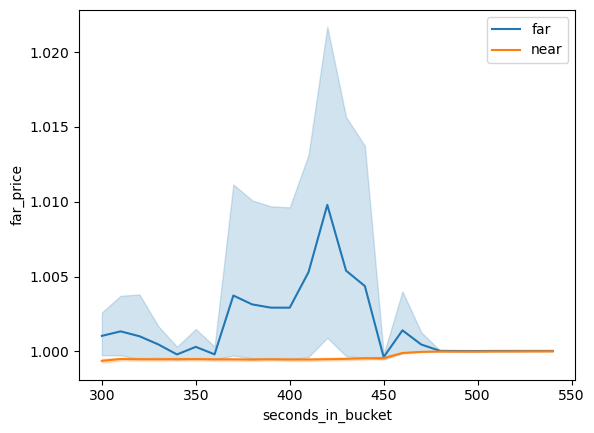

In [210]:
sns.lineplot(data=filtered_df, x='seconds_in_bucket', y='far_price', label='far')
sns.lineplot(data=filtered_df, x='seconds_in_bucket', y='near_price', label='near')

## Временно заполним пустые far просто пустыми near, надо подумать, как их заполнять иначе

In [221]:
def far_price_filler(dataframe: pd.DataFrame) -> pd.DataFrame:
    data = dataframe.copy()
    data_for_fill = data[(data['seconds_in_bucket'] >= 300) & (data['far_price'].isna())]
    
    # Replace missing 'near_price' values based on conditions
    data_for_fill['far_price'] = data_for_fill['near_price']
    
    data = pd.concat([data[data['seconds_in_bucket'] < 300], data_for_fill], axis=0)
    
    return data


In [222]:
a = far_price_filler(filtered_df)
empty_near_price = a.query('near_price.isna() and seconds_in_bucket >=300')
empty_far_price = a.query('far_price.isna() and seconds_in_bucket >=300')

print('empty near price values:', empty_near_price.shape[0])
print('empty far price values:', empty_far_price.shape[0])

empty near price values: 0
empty far price values: 0


In [149]:
def calculate_rsi(data, window_size=14):
    price_diff = data['wap'].diff()
    gain = price_diff.where(price_diff > 0, 0)
    loss = -price_diff.where(price_diff < 0, 0)

    avg_gain = gain.rolling(window=window_size).mean()
    avg_loss = loss.rolling(window=window_size).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

In [157]:
def wap_feats(df):
    window_size = 7
    short_window = 7
    long_window = 30

    # Group by 'stock_id', 'date_id', and 'time_id' and apply the rolling calculations within each group
    #df.loc['rolling_vol'] = df.groupby(['stock_id', 'date_id', 'time_id'])['wap'].pct_change().rolling(window=window_size).std()
    df['vol_st'] = df.groupby(['stock_id'])['wap'].pct_change().rolling(window=window_size).std()
    df['rolling_vol_di'] = df.groupby(['date_id'])['wap'].pct_change().rolling(window=window_size).std()
    df['std_st'] = df.groupby(['stock_id'])['wap'].rolling(window=window_size).std().values
    df['wap_pctch'] = df.groupby(['stock_id','date_id'])['wap'].pct_change().values*100
    df['short_ema'] = df.groupby(['stock_id'])['wap'].ewm(span=short_window, adjust=False).mean().values
    df['long_ema'] = df.groupby(['stock_id'])['wap'].ewm(span=long_window, adjust=False).mean().values
    wap_mean = df['wap'].mean()
    df['wap_vs_market'] = df['wap'] - df.groupby(['stock_id'])['wap'].transform('mean')
    df['macd'] = df['short_ema'] - df['long_ema']
    
    # Bollinger Bands calculation within each stock, date, and time
    df['bollinger_upper'] = df.groupby(['stock_id'])['wap'].rolling(window=long_window).mean().values + 2 * df.groupby(['stock_id'])['wap'].rolling(window=window_size).std().values
    df['bollinger_lower'] = df.groupby(['stock_id'])['wap'].rolling(window=long_window).mean().values - 2 * df.groupby(['stock_id'])['wap'].rolling(window=window_size).std().values
    # RSI calculation within each stock, date, and time
    df['rsi'] = df.groupby(['stock_id']).apply(calculate_rsi).values
    
    return df

In [190]:
train = wap_feats(df)
test = wap_feats(test)

KeyboardInterrupt: 

In [191]:
X = train.drop(["stock_id","date_id", "time_id", "target"],axis=1)
y = train['target']
Tst = test.drop(['stock_id', 'date_id', 'time_id', 'currently_scored'], axis=1)
y_test_test = test_target['revealed_target']
y_test_test= y_test_test.dropna()
features = X.columns.to_list()


X.head(2)

,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,...,rolling_vol_di,std_st,wap_pctch,short_ema,long_ema,wap_vs_market,macd,bollinger_upper,bollinger_lower,rsi
row_id,,,,,,,,,,,,,,,,,,,,,
0_0_0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,...,NaN,NaN,NaN,1.000000,1.000000,0.000158,0.00000,NaN,NaN,NaN
0_0_1,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,...,NaN,NaN,NaN,0.999973,0.999993,0.000071,-0.00002,NaN,NaN,NaN


In [173]:
Tst.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33000 entries, 478_0_0 to 480_540_199
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   seconds_in_bucket        33000 non-null  int64  
 1   imbalance_size           33000 non-null  float64
 2   imbalance_buy_sell_flag  33000 non-null  int64  
 3   reference_price          33000 non-null  float64
 4   matched_size             33000 non-null  float64
 5   far_price                14771 non-null  float64
 6   near_price               15000 non-null  float64
 7   bid_price                33000 non-null  float64
 8   bid_size                 33000 non-null  float64
 9   ask_price                33000 non-null  float64
 10  ask_size                 33000 non-null  float64
 11  wap                      33000 non-null  float64
 12  vol_st                   32794 non-null  float64
 13  rolling_vol_di           32979 non-null  float64
 14  std_st         

In [174]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5237980 entries, 0_0_0 to 480_540_199
Data columns (total 23 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   seconds_in_bucket        int64  
 1   imbalance_size           float64
 2   imbalance_buy_sell_flag  int64  
 3   reference_price          float64
 4   matched_size             float64
 5   far_price                float64
 6   near_price               float64
 7   bid_price                float64
 8   bid_size                 float64
 9   ask_price                float64
 10  ask_size                 float64
 11  wap                      float64
 12  vol_st                   float64
 13  rolling_vol_di           float64
 14  std_st                   float64
 15  wap_pctch                float64
 16  short_ema                float64
 17  long_ema                 float64
 18  wap_vs_market            float64
 19  macd                     float64
 20  bollinger_upper          float64
 21  bolli

In [192]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

#['rolling_volatility', 'wap_std', 'wap_pct_change', 'short_ema', 'long_ema', 'macd', 'bollinger_upper', 'bollinger_lower', 'rsi']

#scaler = StandardScaler()
#X = scaler.fit_transform(X)

imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)
y_imputer = SimpleImputer(strategy='mean')
y = y_imputer.fit_transform(y.values.reshape(-1, 1))
# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tst = imputer.transform(Tst)


# Create a Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X, y)

# Make predictions on the test set
y_pred = model.predict(X)
pred_test = model.predict(tst)

# Calculate MAE
mae = mean_absolute_error(y, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Error (MAE) Test: {mean_absolute_error(y_test_test, pred_test)}")

# Plot coefficients for feature importance
coefs = model.coef_
sorted_idx = np.argsort(np.abs(coefs))[::-1]

# Plot feature coefficients
plt.figure(figsize=(8, 6))
sns.barplot(x=coefs[sorted_idx], y=np.array(features)[sorted_idx], palette='viridis')
plt.title('Feature Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

Mean Absolute Error (MAE): 6.32
Mean Absolute Error (MAE) Test: 5.4876900396001815


IndexError: index 4 is out of bounds for axis 0 with size 1

<Figure size 800x600 with 0 Axes>